#### ok

In [27]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha, rscha
import xyzfield, geofield, trig
import constants
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'font.family': 'Fira Sans Book'})

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

#%matplotlib nbagg


In [2]:
datos = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/output.dat",
                      usecols=(1, 2, 7, 8, 9)).T

thetav = numpy.deg2rad(90 - datos[0])
phiv = numpy.deg2rad(datos[1])

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 50.0))
r_geo, theta_geo, phi_geo = trig.geo2sph(thetav, phiv)

rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r_geo, theta_r, phi_r = scha.rotate_coords(r_geo, theta_geo, phi_geo, rot_mat)

#datos originales, rotados por javi
#Bx, By, Bz = datos[2:]

Bx_o, By_o, Bz_o = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/output.dat",
                      usecols=(4, 5, 6)).T

Bx_r = numpy.empty_like(Bx_o); By_r = numpy.empty_like(By_o); Bz_r = numpy.empty_like(Bz_o)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_o,By_o,Bz_o,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

In [3]:
import scha; importlib.reload(scha)
k_dip, m_dip, n_dip = numpy.atleast_1d((1,), (0,), (1,))
g_dipole=scha.invert_xyz(theta_geo, phi_geo, Bx_o, By_o, Bz_o, (k_dip, m_dip, n_dip))
Bx_dip, By_dip, Bz_dip = scha.xyzfield(k_dip,m_dip,n_dip, g_dipole, theta_geo, phi_geo)
Bx_dip_r = numpy.empty_like(Bx_o); By_dip_r = numpy.empty_like(By_o); Bz_dip_r = numpy.empty_like(Bz_o)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip,By_dip,Bz_dip,thetav,phiv,theta_r)):
    Bx_dip_r[i], By_dip_r[i], Bz_dip_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                               th_i, phi_i, th_ri)

D_dip, I_dip, F_dip, H_dip = xyzfield.xyz2difh(Bx_dip, By_dip, Bz_dip)
D_o, I_o, F_o, H_o = xyzfield.xyz2difh(Bx_o, By_o, Bz_o)
D_r = scha.rotate_declination(D_o, theta_c, phi_c, thetav, phiv, theta_r)
D_res = trig.mindiff(D_o, D_dip)
I_res = trig.mindiff(I_o, I_dip)
F_res = F_o - F_dip

In [ ]:
import field_plots
field_plots.component_residual_plot(theta_r, phi_r, theta_0d, theta_c, phi_c,
                                    (D_dip, I_dip, F_dip),
                                    (D_res, I_res, F_res))

parece okey a priori

In [4]:
theta_0p = theta_0d + 0.1

ms = numpy.arange(0, 7);
roots = scha.degree(ms, theta0 = theta_0p, max_k = 6)
k, m, n = scha.join_roots(roots)

k, m, n = numpy.array((k, m, n))
km_even = ((k-numpy.abs(m)) % 2 == 0) & (k <= 6)
k_even, m_even, n_even = k[km_even], m[km_even], n[km_even]
m_mehler= numpy.array((0, 1, -1, 2, -2))

for ki, mi, ni in zip(k,m,n):
    print(f"{ki:<10} {mi:<10} {ni:<10}")

0.0        0.0        1.1643966587862824e-12
1.0        0.0        4.84731789954003
1.0        1.0        3.6884352103475817
1.0        -1.0       3.6884352103475817
2.0        0.0        8.04745142267155
2.0        1.0        8.047451422671553
2.0        -1.0       8.047451422671553
2.0        2.0        6.437669525128309
2.0        -2.0       6.437669525128309
3.0        0.0        11.78892435975878
3.0        1.0        11.397701824082487
3.0        -1.0       11.397701824082487
3.0        2.0        10.991667046142933
3.0        -2.0       10.991667046142933
3.0        3.0        9.050527164684814
3.0        -3.0       9.050527164684814
4.0        0.0        15.130732030231501
4.0        1.0        15.130732030231501
4.0        -1.0       15.130732030231501
4.0        2.0        14.488366099980672
4.0        -2.0       14.488366099980672
4.0        3.0        13.811848523652548
4.0        -3.0       13.811848523652548
4.0        4.0        11.599762621378055
4.0        -4.0       1

#### vamos a probar scha

In [ ]:
Axyz = scha.condition_matrix_xyz(thetav, phiv, (k,m,n))
Adif = scha.condition_matrix_dif(Bx_dip_r, By_dip_r, Bz_dip_r, F_dip, H_dip, *Axyz)

In [ ]:
importlib.reload(scha)

In [ ]:
gp = scha.invert_dif(theta_r, phi_r, D_r, I_o, F_o, (k,m,n), steps=20)
Dm, Im, Fm, Hm = xyzfield.xyz2difh(*scha.xyzfield(k,m,n,gp,theta_r,phi_r))
field_plots.component_residual_plot(theta_r, phi_r, theta_0p, theta_c, phi_c,
                                    (Dm,Im,Fm),
                                    (trig.mindiff(Dm,D_r), trig.mindiff(Im,I_o), Fm-F_o))

In [ ]:
F_dip_avg=numpy.average(F_dip)
F_res_norm = F_res/F_dip_avg

In [ ]:
Bx_dip_r_norm = Bx_dip_r / F_dip_avg
By_dip_r_norm = By_dip_r / F_dip_avg
Bz_dip_r_norm = Bz_dip_r / F_dip_avg

Adif_norm = scha.condition_matrix_dif(Bx_dip_r_norm, By_dip_r_norm, Bz_dip_r_norm, 
                                      F_dip/F_dip_avg, H_dip/F_dip_avg, *Axyz)

In [ ]:
gpls = numpy.linalg.lstsq(numpy.concatenate(Adif_norm), numpy.concatenate((D_res, I_res, F_res_norm)))[0]
synth = numpy.concatenate(Adif_norm) @ gpls
Ds, Is, Fs = numpy.split(synth, 3)

In [ ]:
gpls

In [ ]:
#gp = scha.invert_dif(theta_r, phi_r, D_res, I_res, F_res, (k,m,n), steps=20)
#Dm, Im, Fm, Hm = xyzfield.xyz2difh(*scha.xyzfield(k,m,n,gpls,theta_r,phi_r))
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (Ds,Is,Fs),
                                    (trig.mindiff(Ds,D_res), trig.mindiff(Is,I_res), Fs-F_res_norm)
                                   )

field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (D_res,I_res,F_res_norm),
                                   )

#### rscha2d

In [5]:
import rscha_r

##### 1. matriz de condición

In [ ]:
Adif_rscha_test = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_geo, theta_r, phi_r, theta_0p,
                                                     Bx_dip_r, By_dip_r, Bz_dip_r))

##### 2. inversión por mínimos cuadrados

In [ ]:
gplsr = numpy.linalg.lstsq(Adif_rscha_test,
                           numpy.concatenate((D_res, I_res, F_res/F_dip_avg)))[0]

##### 3. síntesis (matriz de condición × solución)

In [ ]:
synth = Adif_rscha_test @ gplsr
Ds, Is, Fs = numpy.split(synth, 3)

In [ ]:
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (Ds,Is,Fs),
                                    (trig.mindiff(Ds,D_res), trig.mindiff(Is,I_res), Fs-F_res_norm)
                                   )

##### 4. vuelta al campo total

In [ ]:
#campos remodelados
D_m = D_dip + Ds
I_m = I_dip + Is
F_m = Fs*F_dip_avg + F_dip

In [ ]:
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (D_m,I_m,F_m),
                                    (trig.mindiff(D_m,D_o), trig.mindiff(I_m,I_o), F_m - F_o)
                                   )

In [ ]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(8, 4))

axes[0].hist(numpy.rad2deg(trig.mindiff(D_m,D_o)))
axes[0].set_xlabel("$\Delta D (°)$")
axes[1].hist(numpy.rad2deg(trig.mindiff(I_m,I_o)))
axes[1].set_xlabel("$\Delta I (°)$")
axes[2].hist(F_m-F_o)
axes[2].set_xlabel("$\Delta F (nT)$")

pyplot.show(fig)

ok good nic$e^{1999}$

#### síntesis en otros puntos

In [ ]:
import fibonacci_sphere
import trig
theta_d, phi_d = fibonacci_sphere.grid(n=10000)
in_cap = trig.angulardist(theta_d, phi_d, theta_c, phi_c) < theta_0d
theta_d = theta_d[in_cap]
phi_d = phi_d[in_cap]
r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, phi_dg, rot_mat)
Bx_dip_d, By_dip_d, Bz_dip_d = scha.xyzfield(k_dip,m_dip,n_dip, g_dipole, theta_dg, phi_dg)

Bx_dip_dr = numpy.empty_like(Bx_dip_d); By_dip_dr = Bx_dip_dr.copy(); Bz_dip_dr = Bx_dip_dr.copy()

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip_d,By_dip_d,Bz_dip_d,theta_dg,phi_dg,theta_dgr)):
    Bx_dip_dr[i], By_dip_dr[i], Bz_dip_dr[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                                  th_i, phi_i, th_ri)



In [ ]:
Adif_syn = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_dgr, theta_dgr, phi_dgr, theta_0p,
                                                     Bx_dip_dr, By_dip_dr, Bz_dip_dr))

In [ ]:
synth_d = Adif_syn @ gplsr
Ds_d, Is_d, Fs_d = numpy.split(synth_d, 3)

In [ ]:
field_plots.component_residual_plot(theta_dgr, phi_dgr, theta_0, theta_c, phi_c,
                                    (Ds_d,Is_d,Fs_d),
                                   )

In [ ]:
fig, axes = pyplot.subplots(1,3, figsize=(8,4))
axes[0].hist((Ds_d, Ds, D_res), color=('C4', 'C0', 'C2'), normed=True); axes[0].set_xlabel("D")
axes[1].hist((Is_d, Is, I_res), color=('C4', 'C0', 'C2'), normed=True); axes[1].set_xlabel("I")
axes[2].hist((Fs_d, Fs, F_res_norm), color=('C4', 'C0', 'C2'), normed=True); axes[2].set_xlabel("F")
pyplot.show(fig)

vale, se puede modelar, bien

#### el tiempo: una gran cosa
vamos a usar los datos sintetizados con sha para poder hacer la magia. esto significa que cambiaremos los parametrororororos

In [6]:
#la data

datos_t = numpy.loadtxt("../data/rscha2d/dato_synt_sha.dat", skiprows=1).T

tv = datos_t[0]
thetav = numpy.deg2rad(90-datos_t[1])
phiv = numpy.deg2rad(datos_t[2])
D_o = numpy.deg2rad(datos_t[3])
I_o = numpy.deg2rad(datos_t[4])
F_o = datos_t[6]

#conversión a esféricas
r_geo, theta_geo, phi_geo = trig.geo2sph(thetav, phiv)

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-42.0, 20.0, 26.0, 50.0))
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r_geo, theta_r, phi_r = scha.rotate_coords(r_geo, theta_geo, phi_geo, rot_mat)

#en primera aproximación, a falta de algo más mejor
g01_dip = -30.0

#síntesis del dipolo en todos los datas
Bx_dip, By_dip, Bz_dip = scha.xyzfield((1,), (0,), (1,), (g01_dip,), theta_geo, phi_geo)
Bx_dip_r = numpy.empty_like(Bx_dip); By_dip_r = numpy.empty_like(By_dip); Bz_dip_r = numpy.empty_like(Bz_dip)
for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip,By_dip,Bz_dip,thetav,phiv,theta_r)):
    Bx_dip_r[i], By_dip_r[i], Bz_dip_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                               th_i, phi_i, th_ri)
    
D_dip, I_dip, F_dip, H_dip = xyzfield.xyz2difh(Bx_dip, By_dip, Bz_dip)

D_res = trig.mindiff(D_o, D_dip)
I_res = trig.mindiff(I_o, I_dip)
F_res = F_o - F_dip

In [7]:
import field_plots; importlib.reload(field_plots)
pyplot.show(field_plots.component_residual_plot(theta_r, phi_r, theta_0d, theta_c, phi_c,
                                    (D_dip, I_dip, F_dip),
                                    (D_res, I_res, F_res)))

20.0 42.0


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Fira Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


ValueError: Both *x_transform* and *y_transform* must be 2D affine transforms.

**ok** _(tengamos en cuenta que los datos son de tiempos distintos, lo que justifica el jaleito)_

In [8]:
import bspline
knots = numpy.arange(-2100, 2050, 50)

At = bspline.condition_array(knots, tv)

el poder de la sabiduría mágica te acompañará
- posibilidad: 2 much splinge?
- wow such density i thin k i just boom

vamos a modelar

In [9]:
theta_0p = theta_0d + 0.1

ms = numpy.arange(0, 4);
roots = scha.degree(ms, theta0 = theta_0p, max_k = 3)
k, m, n = scha.join_roots(roots)

k, m, n = numpy.array((k, m, n))
km_even = ((k-numpy.abs(m)) % 2 == 0) & (k <= 3)
k_even, m_even, n_even = k[km_even], m[km_even], n[km_even]
m_mehler= numpy.array((0, 1, -1, 2, -2))

for ki, mi, ni in zip(k,m,n):
    print(f"{ki:<10} {mi:<10} {ni:<10}")

0.0        0.0        1.1645544163875254e-12
1.0        0.0        3.832784276992117
1.0        1.0        2.933925280459704
1.0        -1.0       2.933925280459704
2.0        0.0        6.4375331855248525
2.0        1.0        6.4375331855248525
2.0        -1.0       6.4375331855248525
2.0        2.0        5.18438704387763
2.0        -2.0       5.18438704387763
3.0        0.0        9.463634429388543
3.0        1.0        9.15881506806791
3.0        -1.0       9.15881506806791
3.0        2.0        8.842537127766702
3.0        -2.0       8.842537127766702
3.0        3.0        7.328856948394158
3.0        -3.0       7.328856948394158


In [10]:
#super mega ultra condition matrix:
Adif_rscha_test = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_geo, theta_r, phi_r, theta_0p,
                                                     Bx_dip_r, By_dip_r, Bz_dip_r))

At3 = numpy.vstack((At, At, At))
Adift = numpy.concatenate([Adif_rscha_test*At3[:, i:i+1] for i in range(len(knots))], axis=1)
#puede ser correcto bien

In [11]:
F_dip_avg=numpy.average(F_dip)
F_res_norm = F_res/F_dip_avg

In [12]:
gptlsr = numpy.linalg.lstsq(Adift, numpy.concatenate((D_res, I_res, F_res/F_dip_avg)))[0]

In [13]:
synth = Adift @ gptlsr
Ds, Is, Fs = numpy.split(synth, 3)

In [14]:
#campos remodelados
D_m = D_dip + Ds
I_m = I_dip + Is
F_m = Fs*F_dip_avg + F_dip

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Fira Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


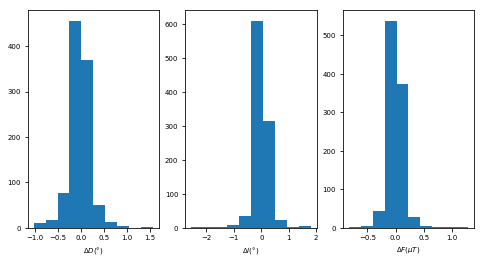

In [15]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(8, 4))

axes[0].hist(numpy.rad2deg(trig.mindiff(D_m,D_o)))
axes[0].set_xlabel("$\Delta D (°)$")
axes[1].hist(numpy.rad2deg(trig.mindiff(I_m,I_o)))
axes[1].set_xlabel("$\Delta I (°)$")
axes[2].hist(F_m-F_o)
axes[2].set_xlabel("$\Delta F (\mu T)$")

pyplot.show(fig)

- wow funciona sin regularizar! (mira esos residuos ridículos, oh my god)
- pero _**claro**_
 - seguramente la síntesis en otros puntos y tiempos sea horrible

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Fira Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


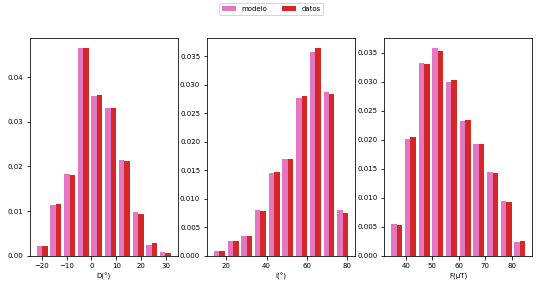

In [16]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(9, 4))

axes[0].hist((numpy.rad2deg(D_m), numpy.rad2deg(D_o)), color=("C6", "C3"), label=("modelo", "datos"), normed=True)
axes[0].set_xlabel("D(°)")
axes[1].hist((numpy.rad2deg(I_m), numpy.rad2deg(I_o)), color=("C6", "C3"), normed=True)
axes[1].set_xlabel("I(°)")
axes[2].hist((F_m, F_o), color=("C6", "C3"), normed=True)
axes[2].set_xlabel("F(μT)")

fig.legend(*axes[0].get_legend_handles_labels(), 'upper center', ncol=2)

pyplot.show(fig)

#### las grandes aventuras de la síntesis

In [17]:
import field_plots

In [ ]:
import fibonacci_sphere
import trig
theta_d, phi_d = fibonacci_sphere.grid(n=7500)
in_cap = trig.angulardist(theta_d, phi_d, theta_c, phi_c) < theta_0p
theta_d = theta_d[in_cap]
phi_d = phi_d[in_cap]

#t_d = knots
t_d = [1940,]
nd = len(theta_d)
theta_d = numpy.tile(theta_d, len(t_d))
phi_d = numpy.tile(phi_d, len(t_d))
times_d = numpy.repeat(t_d, nd)

r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, phi_dg, rot_mat)
Bx_dip_d, By_dip_d, Bz_dip_d = scha.xyzfield(k_dip,m_dip,n_dip, (g01_dip,), theta_dg, phi_dg)

Bx_dip_dr = numpy.empty_like(Bx_dip_d); By_dip_dr = Bx_dip_dr.copy(); Bz_dip_dr = Bx_dip_dr.copy()

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip_d,By_dip_d,Bz_dip_d,theta_dg,phi_dg,theta_dgr)):
    Bx_dip_dr[i], By_dip_dr[i], Bz_dip_dr[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                                  th_i, phi_i, th_ri)    

Adif_syn = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_dgr, theta_dgr, phi_dgr, theta_0p,
                                                     Bx_dip_dr, By_dip_dr, Bz_dip_dr))

A3t_syn = numpy.vstack([bspline.condition_array(knots, times_d)]*3)
Adift_syn = numpy.concatenate([Adif_syn*A3t_syn[:, i:i+1] for i in range(len(knots))], axis=1)


In [ ]:
del Adif_syn, A3t_syn

In [ ]:
synth_d = Adift_syn @ gptlsr
Ds_d, Is_d, Fs_d = numpy.split(synth_d, 3)

D_dip_d, I_dip_d, F_dip_d, H_dip_d = xyzfield.xyz2difh(Bx_dip_d, By_dip_d, Bz_dip_d)

D_m = D_dip_d + Ds_d
I_m = I_dip_d + Is_d
F_m = Fs_d*F_dip_avg + F_dip_d

In [ ]:
importlib.reload(field_plots); importlib.reload(scha)
field_plots.component_residual_plot(theta_dgr, phi_dgr, theta_0p, theta_c, phi_c,
                                    (numpy.rad2deg(D_m), numpy.rad2deg(I_m), F_m),
                                    scales=("symmetric", "positive", "positive"),
                                    cmaps=("Spectral", "Spectral", "Spectral"),
                                    lines=True)

 - pues así a priori parece que no lo es
 - do a big heck yes

In [18]:
import coords; importlib.reload(coords)

<module 'coords' from '/home/josecper/Programs/python/coords.py'>

In [19]:
#madrid
#theta_at, phi_at = numpy.deg2rad((90 - 40.423, -3.7))

#viena
theta_at, phi_at = numpy.deg2rad((90-48.221717, 16.397197))

#estambul
#theta_at, phi_at = numpy.deg2rad((90-41.025258, 28.992250))

times = numpy.linspace(-2000, 1900, 300)
times_d, r_d, theta_d, phi_d = coords.curve_at(times, constants.a_r, theta_at, phi_at)

r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, phi_dg, rot_mat)
Bx_dip_d, By_dip_d, Bz_dip_d = scha.xyzfield(k_dip,m_dip,n_dip, (g01_dip,), theta_dg, phi_dg)

Bx_dip_dr = numpy.empty_like(Bx_dip_d); By_dip_dr = Bx_dip_dr.copy(); Bz_dip_dr = Bx_dip_dr.copy()

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip_d,By_dip_d,Bz_dip_d,theta_dg,phi_dg,theta_dgr)):
    Bx_dip_dr[i], By_dip_dr[i], Bz_dip_dr[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                                  th_i, phi_i, th_ri)    

Adif_syn = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_dgr, theta_dgr, phi_dgr, theta_0p,
                                                     Bx_dip_dr, By_dip_dr, Bz_dip_dr))

A3t_syn = numpy.vstack([bspline.condition_array(knots, times_d)]*3)
Adift_syn = numpy.concatenate([Adif_syn*A3t_syn[:, i:i+1] for i in range(len(knots))], axis=1)


In [20]:
del Adif_syn, A3t_syn

In [21]:
synth_d = Adift_syn @ gptlsr
Ds_d, Is_d, Fs_d = numpy.split(synth_d, 3)

D_dip_d, I_dip_d, F_dip_d, H_dip_d = xyzfield.xyz2difh(Bx_dip_d, By_dip_d, Bz_dip_d)

D_m = D_dip_d + Ds_d
I_m = I_dip_d + Is_d
F_m = Fs_d*F_dip_avg + F_dip_d

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Fira Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


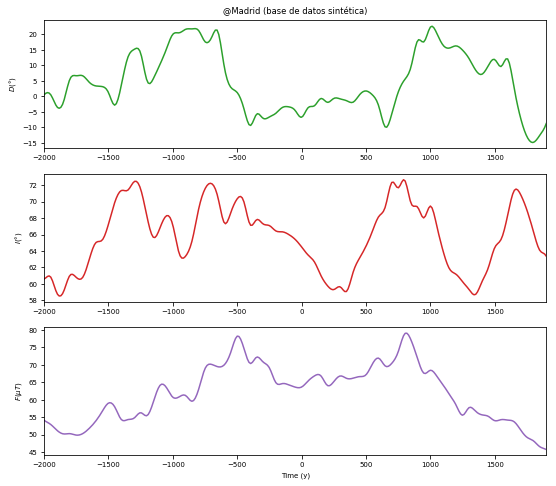

In [22]:
fig, axes = pyplot.subplots(3, 1, figsize=(9,8))

axes[0].set_title("@Madrid (base de datos sintética)")

axes[0].plot(times_d, numpy.rad2deg(D_m), color="C2")
axes[0].set_ylabel("$D (°)$")

axes[1].plot(times_d, numpy.rad2deg(I_m), color="C3")
axes[1].set_ylabel("$I (°)$")

axes[2].plot(times_d, F_m, color="C4")
axes[2].set_ylabel("$F (\mu T)$")

axes[2].set_xlabel("Time (y)")


for ax in axes:
    ax.set_xbound(-2000, 1900)
    
pyplot.show(fig)

In [28]:
import coords; importlib.reload(field_plots)
import fibonacci_sphere
times_long = numpy.arange(-2000, 2000, 100)

theta_in, phi_in = fibonacci_sphere.grid(n=7500)
in_cap = trig.angulardist(theta_in, phi_in, theta_c, phi_c) < theta_0p
theta_in = theta_in[in_cap]
phi_in = phi_in[in_cap]

lon_c, lat_c = numpy.rad2deg((phi_c, numpy.pi/2 - theta_c))
base_cap = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-numpy.rad2deg(theta_0p))
base_world = Basemap(projection="aeqd", lon_0 = lon_c, lat_0 = lat_c, lat_ts=45.0,
                    width=base_cap.xmax, height=base_cap.ymax, resolution="l")

for jj, time in enumerate(times_long):

    timev = numpy.atleast_1d(time)
    times_d, r_d, theta_d, phi_d = coords.anything(numpy.ones_like(theta_in)*constants.a_r,
                                                   theta_in,
                                                   phi_in,
                                                   timev)

    r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
    r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, phi_dg, rot_mat)
    Bx_dip_d, By_dip_d, Bz_dip_d = scha.xyzfield(k_dip,m_dip,n_dip, (g01_dip,), theta_dg, phi_dg)

    Bx_dip_dr = numpy.empty_like(Bx_dip_d); By_dip_dr = Bx_dip_dr.copy(); Bz_dip_dr = Bx_dip_dr.copy()

    for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip_d,By_dip_d,Bz_dip_d,theta_dg,phi_dg,theta_dgr)):
        Bx_dip_dr[i], By_dip_dr[i], Bz_dip_dr[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                                      th_i, phi_i, th_ri)    

    Adif_syn = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                         (k_even[1:], m_even[1:], n_even[1:]),
                                                         m_mehler,
                                                         r_dgr, theta_dgr, phi_dgr, theta_0p,
                                                         Bx_dip_dr, By_dip_dr, Bz_dip_dr))

    A3t_syn = numpy.vstack([bspline.condition_array(knots, times_d)]*3)
    Adift_syn = numpy.concatenate([Adif_syn*A3t_syn[:, i:i+1] for i in range(len(knots))], axis=1)

    del Adif_syn, A3t_syn

    synth_d = Adift_syn @ gptlsr
    Ds_d, Is_d, Fs_d = numpy.split(synth_d, 3)

    D_dip_d, I_dip_d, F_dip_d, H_dip_d = xyzfield.xyz2difh(Bx_dip_d, By_dip_d, Bz_dip_d)

    D_m = D_dip_d + Ds_d
    I_m = I_dip_d + Is_d
    F_m = Fs_d*F_dip_avg + F_dip_d
    
    # numpy.savetxt('../data/rscha2d/mapas/dif_{:04d}_({}).txt'.format(jj, time),
    #              numpy.stack((theta_dgr, phi_dgr, D_m, I_m, F_m)).T)
    
    fig = field_plots.component_residual_plot(theta_dgr, phi_dgr, theta_0p, theta_c, phi_c,
                    (numpy.rad2deg(D_m), numpy.rad2deg(I_m), F_m),
                    scales=("symmetric", "positive", "positive"),
                    cmaps=("Spectral", "Spectral", "Spectral"),
                    titles=("D (°)", "I (°)", "F $(\mu T)$"),
                    lines=True)
    fig.suptitle('t = {} years AD'.format(time))
    fig.savefig('../data/rscha2d/mapas/rscha2d_{jj:04d}_{time:d}.png'.format(jj=jj, time=int(time)),
                frameon=True)
    pyplot.close(fig)


20.0 42.0


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Fira Sans Book'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0
20.0 42.0


#### debugin zone

In [ ]:
pyplot.close('all')